# Package

In [11]:
!pip install pgmpy
!pip install lingam
!pip install networkx
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install gcastle


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 3.5 MB/s eta 0:00:00


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 导入数据

In [59]:
!ls

261_figures  Copilot  DiT	 dreamerv3-torch  miniconda3  ObjectLearning
CausalGPT    CVM      dreamerv3  logdir		  MMCRL       R


In [2]:
import pandas as pd
import numpy as np
# 定义文件路径
# datasets = {
#     '500': '/content/drive/MyDrive/Data/station_data_500.csv',
#     '1000': '/content/drive/MyDrive/Data/station_data_1000.csv',
#     '2000': '/content/drive/MyDrive/Data/station_data_2000.csv',
# }

root_dir = 'Copilot/261_data/Data 3'
figure_dir = 'Copilot/261_figures'

datasets = {
    '500': f'{root_dir}/station_data_500.csv',
    '1000': f'{root_dir}/station_data_1000.csv',
    '2000': f'{root_dir}/station_data_2000.csv',
}

# ground_truth_path = '/content/drive/MyDrive/Data/station_ground_truth.csv'
ground_truth_path = f'{root_dir}/station_ground_truth.csv'

# 加载 Ground Truth 数据
ground_truth_df = pd.read_csv(ground_truth_path)
print("Ground Truth Data:")
print(ground_truth_df.head())

# 加载每个数据集
dataframes = {}
for key, path in datasets.items():
    print(f"\nLoading dataset with {key} samples:")
    dataframes[key] = pd.read_csv(path)
    print(dataframes[key].head())
# 加载并处理 Ground Truth 数据
ground_truth_df = pd.read_csv(ground_truth_path, index_col=0)

# 根据列名动态分组
stations_ground_truth = {}
for station in ['Station1', 'Station2', 'Station3']:
    station_cols = [col for col in ground_truth_df.columns if col.startswith(station)]
    stations_ground_truth[station] = ground_truth_df[station_cols].filter(items=station_cols, axis=0).values

    # 确保矩阵是数值类型
    stations_ground_truth[station] = np.array(stations_ground_truth[station], dtype=float)

print("Processed Ground Truth Matrices:")
for station, matrix in stations_ground_truth.items():
    print(f"\n{station}:")
    print(matrix)


Ground Truth Data:
      Unnamed: 0  Station1_mp_0  Station1_mp_1  Station1_mp_2  Station1_mp_3  \
0  Station1_mp_0            0.0            1.0            1.0            0.0   
1  Station1_mp_1            0.0            0.0            1.0            0.0   
2  Station1_mp_2            0.0            0.0            0.0            0.0   
3  Station1_mp_3            0.0            0.0            0.0            0.0   
4  Station1_mp_4            0.0            0.0            0.0            0.0   

   Station1_mp_4  Station1_mp_5  Station2_mp_6  Station2_mp_7  Station2_mp_8  \
0            0.0            0.0            0.0            0.0            0.0   
1            1.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            1.0            1.0            0.0            0.0            0.0   
4            0.0            1.0            0.0            0.0            0.0   

   ...  Station3_mp

## Functions

In [3]:
import os

from castle.common import GraphDAG
from castle.metrics import MetricsDAG
from causallearn.search.ScoreBased.GES import ges
import json

import warnings
warnings.filterwarnings("ignore")

def run_causal_discovery_by_station(algorithm_class, datasets, stations_ground_truth, save=True, visualize=False, kwargs=None):
    """
    Run a causal discovery algorithm on different station datasets.
    
    Args:
        algorithm_class: A class from castle.algorithms (e.g. PC, GES, etc.)
        datasets: Dictionary mapping sample sizes to dataset file paths
        stations_ground_truth: Dictionary mapping station names to ground truth matrices
        save: Whether to save results and figures to files
        visualize: Whether to display figures in notebook
        kwargs: Additional arguments for the algorithm
    
    Returns:
        Dictionary containing results for each sample size and station
    """
    results = {}

    # Process each dataset size
    for n_samples, file_path in datasets.items():
        results[n_samples] = {}

        # Load dataset
        data = pd.read_csv(file_path)

        # Group by station
        station_data = {}
        for station in ['Station1', 'Station2', 'Station3']:
            station_cols = [col for col in data.columns if col.startswith(station)]
            station_data[station] = data[station_cols].values

        # Run algorithm for each station
        for station, station_matrix in station_data.items():
            if algorithm_class == ges:
                Record = algorithm_class(station_matrix)
                G = Record['G'].graph
                pred_graph = np.zeros_like(G)
                n = G.shape[0]
                for i in range(n):
                    for j in range(n):
                        # only consider directed edges to align with the gcastle's format
                        if G[j,i] == 1 and G[i,j] == -1:
                            pred_graph[i,j] = 1  # i->j
                        elif G[i,j] == -1 and G[j,i] == -1 and pred_graph[i,j] == 0 and pred_graph[j,i] == 0:
                            if np.random.random() < 0.5:
                                pred_graph[i,j] = 1  # i->j 
                            else:
                                pred_graph[j,i] = 1  # j->i
                algorithm = 'GES'
            else:
                if kwargs is not None:
                    algorithm = algorithm_class(**kwargs)
                else:
                    algorithm = algorithm_class()
                algorithm.learn(station_matrix)
                pred_graph = np.array(algorithm.causal_matrix, dtype=float)

            # Calculate metrics
            mt = MetricsDAG(pred_graph, stations_ground_truth[station])

            # Store results
            if station not in results[n_samples]:
                results[n_samples][station] = {}
            results[n_samples][station]['pred_graph'] = pred_graph.tolist()
            results[n_samples][station]['metrics'] = mt.metrics

            # Save/visualize graphs
            if save or visualize:
                os.makedirs(figure_dir, exist_ok=True)
                algo_name = algorithm if isinstance(algorithm, str) else algorithm.__class__.__name__
                
                if save:
                    # Create subdirectories for organization
                    save_dir = os.path.join(figure_dir, 'by_station', algo_name, station)
                    os.makedirs(save_dir, exist_ok=True)
                    GraphDAG(pred_graph, stations_ground_truth[station], show=visualize,
                            save_name=f'{save_dir}/{n_samples}_samples')

    # Save results to file if requested
    if save:
        results_dir = os.path.join(figure_dir, 'results', 'by_station')
        os.makedirs(results_dir, exist_ok=True)
        algo_name = algorithm if isinstance(algorithm, str) else algorithm.__class__.__name__
        with open(f'{results_dir}/{algo_name}_results.json', 'w') as f:
            json.dump(results, f, indent=4)

    return results

def run_causal_discovery_all_stations(algorithm_class, datasets, ground_truth_path, save=True, visualize=False, kwargs=None):
    # Load and process ground truth data
    ground_truth_df = pd.read_csv(ground_truth_path, index_col=0)
    true_graph = np.array(ground_truth_df.values, dtype=float)

    # Dictionary to store results
    results = {}

    # Process each dataset
    for n_samples, file_path in datasets.items():
        results[n_samples] = {}

        # Load dataset
        data = pd.read_csv(file_path)
        data = data.select_dtypes(include=[np.number]).values

        # Fit the model
        if algorithm_class == ges:
            Record = algorithm_class(data)
            G = Record['G'].graph
            pred_graph = np.zeros_like(G)
            n = G.shape[0]
            for i in range(n):
                for j in range(n):
                     # only consider directed edges to align with the gcastle's format
                    if G[j,i] == 1 and G[i,j] == -1:
                        pred_graph[i,j] = 1  # i->j
                    elif G[i,j] == -1 and G[j,i] == -1 and pred_graph[i,j] == 0 and pred_graph[j,i] == 0:
                        if np.random.random() < 0.5:
                            pred_graph[i,j] = 1  # i->j 
                        else:
                            pred_graph[j,i] = 1  # j->i
            algorithm = 'GES'
        else:
            if kwargs is not None:
                algorithm = algorithm_class(**kwargs)
            else:
                algorithm = algorithm_class()
            algorithm.learn(data)
            pred_graph = np.array(algorithm.causal_matrix, dtype=float)

        # Calculate metrics
        mt = MetricsDAG(pred_graph, true_graph)

        # Store results
        results[n_samples]['pred_graph'] = pred_graph.tolist()
        results[n_samples]['metrics'] = mt.metrics

        # Save/visualize graphs
        if save or visualize:
            os.makedirs(figure_dir, exist_ok=True)
            algo_name = algorithm if isinstance(algorithm, str) else algorithm.__class__.__name__
            
            if save:
                # Create subdirectories for organization
                save_dir = os.path.join(figure_dir, 'all_stations', algo_name)
                os.makedirs(save_dir, exist_ok=True)
                GraphDAG(pred_graph, true_graph, show=visualize,
                        save_name=f'{save_dir}/{n_samples}_samples')

    # Save results to file if requested
    if save:
        results_dir = os.path.join(figure_dir, 'results', 'all_stations')
        os.makedirs(results_dir, exist_ok=True)
        algo_name = algorithm if isinstance(algorithm, str) else algorithm.__class__.__name__
        with open(f'{results_dir}/{algo_name}_results.json', 'w') as f:
            json.dump(results, f, indent=4)

    return results

# Algorithms

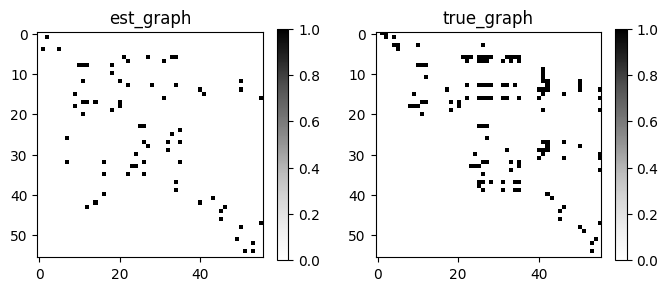

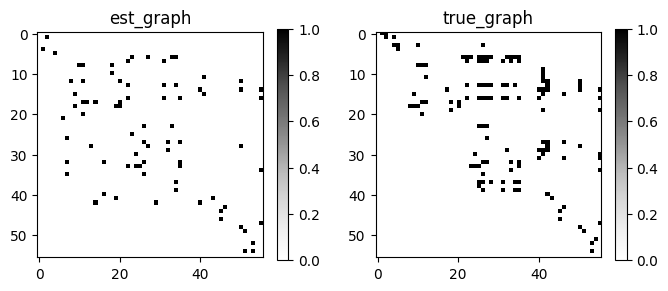

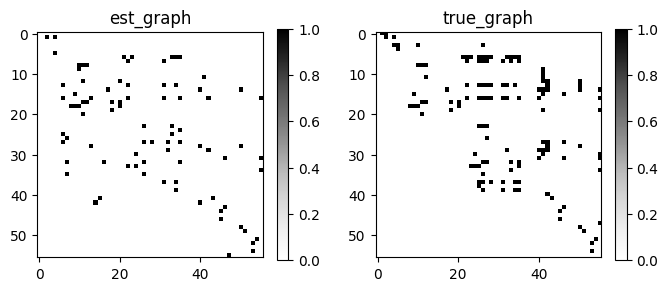

In [15]:
# Import causal discovery methods
os.environ['CASTLE_BACKEND'] ='pytorch'

from castle.algorithms import PC, DirectLiNGAM, DAG_GNN, Notears, GOLEM
from causallearn.search.ScoreBased.GES import ges

# Define algorithm configurations
algorithm_configs = [
    # (PC, None),
    # (DirectLiNGAM, None),
    (ges, None),
    # (DAG_GNN, {'epochs': 100, 'batch_size': 1024, 'device_type': 'gpu', 'device_ids': 0}),
    # (Notears, {'max_iter': 1000}),
    # (GOLEM, {'num_iter': 1000, 'device_type': True, 'device_ids': 0})
]

# Run algorithms sequentially
results = []
for algo, kwargs in algorithm_configs:
    # station_results = run_causal_discovery_by_station(algo, datasets, stations_ground_truth, kwargs=kwargs)
    all_results = run_causal_discovery_all_stations(algo, datasets, ground_truth_path, kwargs=kwargs)
    # results.append((station_results, all_results))
    

## Visualization

In [16]:
# load data from the json files
def load_results(figure_dir):
    results = {}
    
    # Load results for each algorithm
    for algo_name in ['PC', 'DirectLiNGAM', 'DAG_GNN', 'GOLEM', 'GES', 'Notears']:
        results[algo_name] = {
            'by_station': None,
            'all_stations': None
        }
        
        # Load by_station results
        station_path = os.path.join(figure_dir, 'results', 'by_station', f'{algo_name}_results.json')
        if os.path.exists(station_path):
            with open(station_path, 'r') as f:
                results[algo_name]['by_station'] = json.load(f)
                
        # Load all_stations results
        all_path = os.path.join(figure_dir, 'results', 'all_stations', f'{algo_name}_results.json')
        if os.path.exists(all_path):
            with open(all_path, 'r') as f:
                results[algo_name]['all_stations'] = json.load(f)
                
    return results

# Load results for each algorithm
results_dict = load_results(figure_dir)


### How metrics (SHD) of different algorithms change with sample size for each station

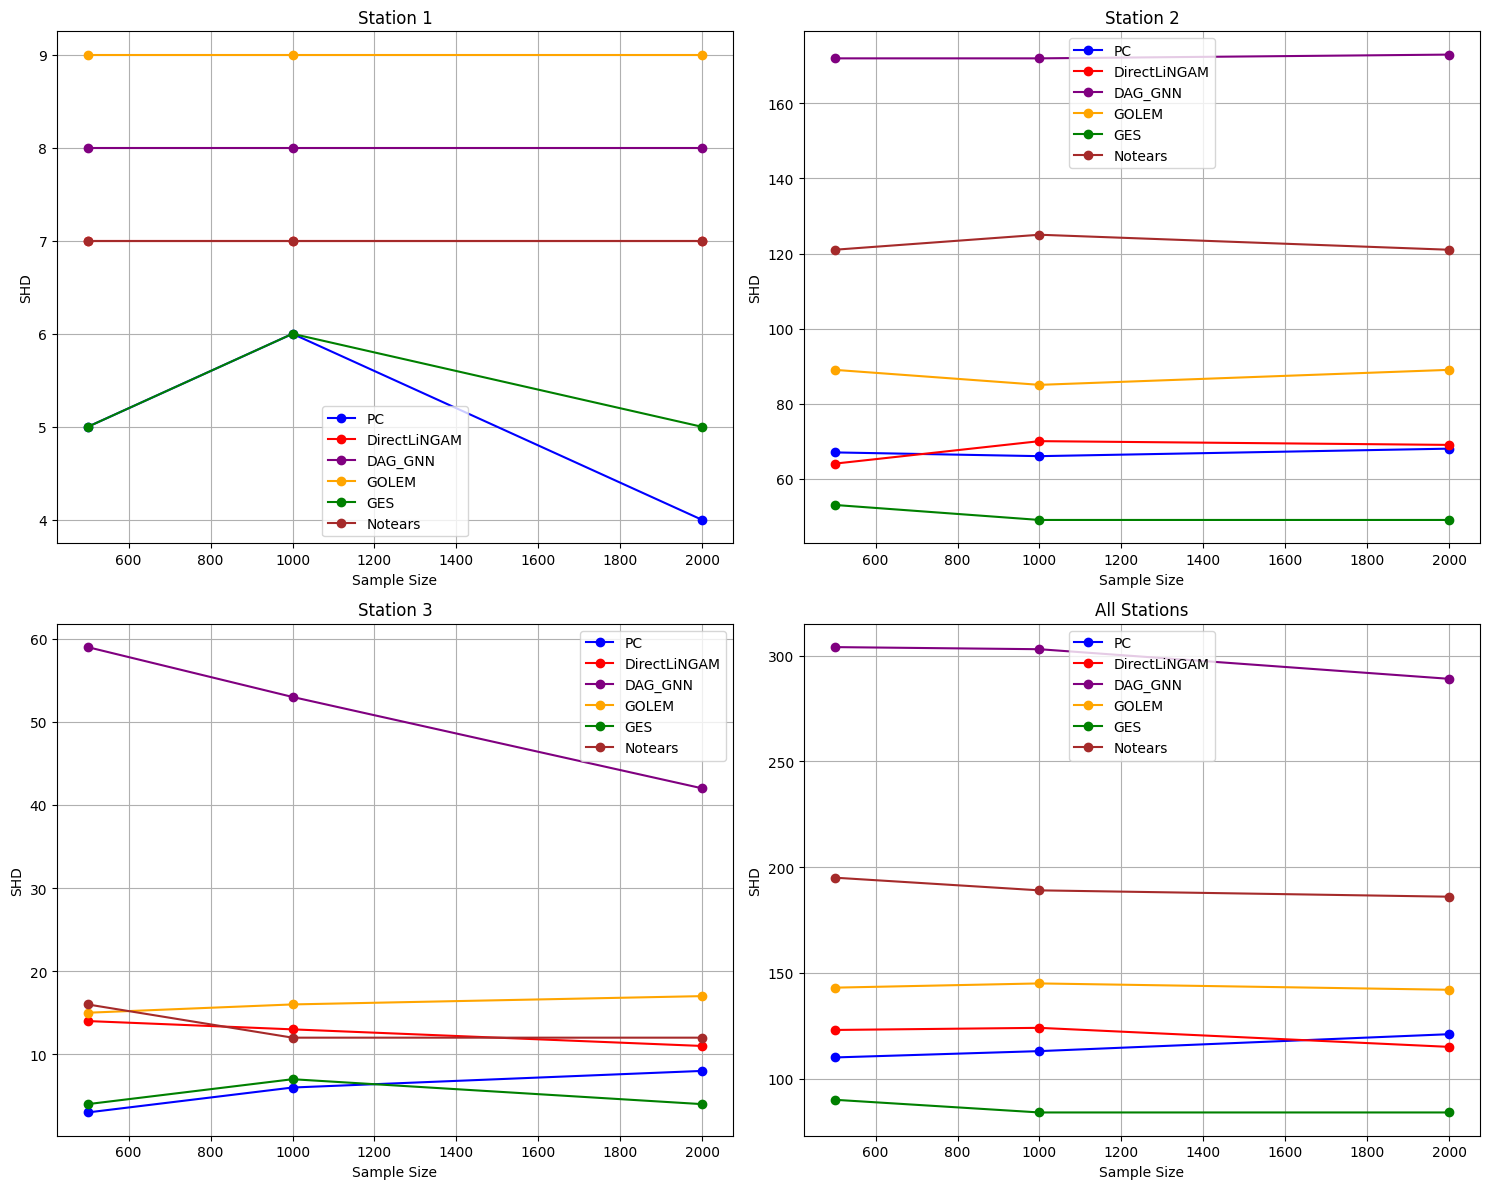

In [17]:
import matplotlib.pyplot as plt

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# Plot titles
titles = ['Station 1', 'Station 2', 'Station 3', 'All Stations']

# Colors for each algorithm
colors = {'PC': 'blue', 'DirectLiNGAM': 'red', 'GES': 'green',
          'DAG_GNN': 'purple', 'GOLEM': 'orange', 'Notears': 'brown'}

for idx, title in enumerate(titles):
    ax = axes[idx]
    
    # For each algorithm
    for algo in results_dict.keys():
        sample_sizes = []
        shd_values = []
        
        # Get data based on station vs all
        if title == 'All Stations':
            data = results_dict[algo]['all_stations']
            if data is not None:  # Check for None
                for n_samples, results in data.items():
                    if results is not None and 'metrics' in results and 'shd' in results['metrics']:
                        sample_sizes.append(int(n_samples))
                        shd_values.append(results['metrics']['shd'])
        else:
            data = results_dict[algo]['by_station']
            station_num = title.split()[-1]
            if data is not None:  # Check for None
                for n_samples, stations in data.items():
                    if stations is not None and f'Station{station_num}' in stations:
                        station_data = stations[f'Station{station_num}']
                        if station_data is not None and 'metrics' in station_data and 'shd' in station_data['metrics']:
                            sample_sizes.append(int(n_samples))
                            shd_values.append(station_data['metrics']['shd'])
        
        if sample_sizes:  # Only plot if we have valid data
            ax.plot(sample_sizes, shd_values, 'o-', label=algo, color=colors[algo])
    
    ax.set_title(title)
    ax.set_xlabel('Sample Size')
    ax.set_ylabel('SHD')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

### For each station (different complexities), how different algorithms perform (conditioned on the largest sample size)


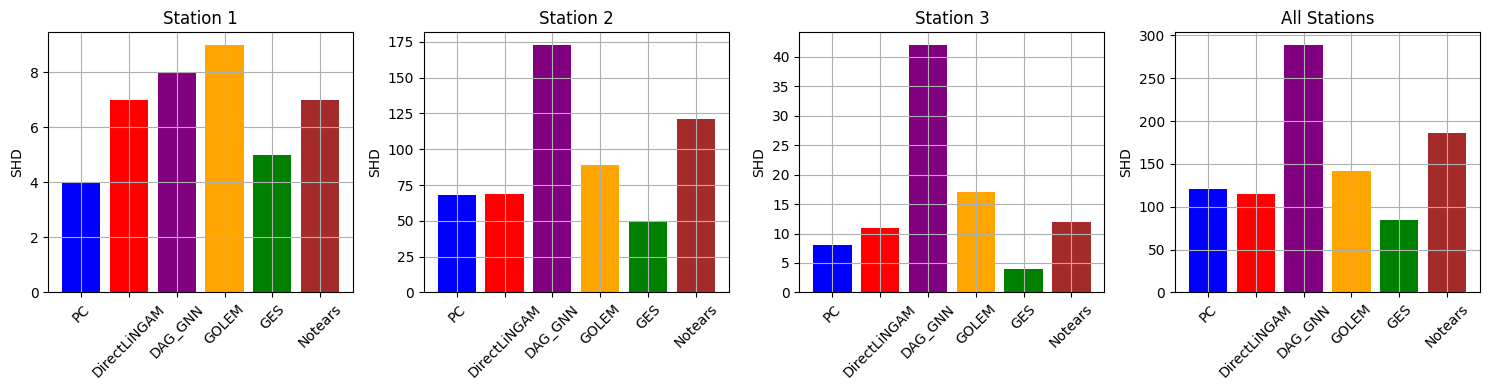

In [18]:
# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
titles = ['Station 1', 'Station 2', 'Station 3', 'All Stations']

# Colors for each algorithm
colors = {'PC': 'blue', 'DirectLiNGAM': 'red', 'GES': 'green',
          'DAG_GNN': 'purple', 'GOLEM': 'orange', 'Notears': 'brown'}

# Get the largest sample size
max_sample_size = '2000'  # Based on the data structure

for idx, title in enumerate(titles):
    ax = axes[idx]
    
    # Store results for each algorithm
    algo_results = []
    algo_names = []
    
    # For each algorithm
    for algo in results_dict.keys():
        # Get data based on station vs all
        if title == 'All Stations':
            data = results_dict[algo]['all_stations']
            if data and max_sample_size in data:
                algo_results.append(data[max_sample_size]['metrics']['shd'])
                algo_names.append(algo)
        else:
            data = results_dict[algo]['by_station']
            station_num = title.split()[-1]
            if data and max_sample_size in data:
                if f'Station{station_num}' in data[max_sample_size]:
                    algo_results.append(data[max_sample_size][f'Station{station_num}']['metrics']['shd'])
                    algo_names.append(algo)
    
    # Create bar plot
    bars = ax.bar(range(len(algo_names)), algo_results, color=[colors[algo] for algo in algo_names])
    
    ax.set_title(title)
    ax.set_ylabel('SHD')
    ax.set_xticks(range(len(algo_names)))
    ax.set_xticklabels(algo_names, rotation=45)
    ax.grid(True)

plt.tight_layout()
plt.show()

### How does score-based methods perform compared to constraint-based methods and functional model-based methods?

In [ ]:
# a subset of the figure above

### How does different score-based methods perform (conditioned on the largest sample size)? Did any

In [ ]:
# a subset of the figure above

### Bootstrapping for prediction uncertainty

In [9]:
# only use the smallest station and smallest sample size for bootstrapping 10 times, and aggregate the disagreement of all edges of a specific algorithm
# then plot the aggregateddisagreement for each algorithm in a bar plot (mean +- std)

# Set parameters
n_bootstrap = 100
station = 'Station1'  # Use smallest station
min_sample_size = str(min(int(n) for n in datasets.keys()))  # Use smallest sample size

# Dictionary to store edge disagreements for each algorithm
edge_uncertainties = {}

# Set threshold for edge stability
STABILITY_THRESHOLD = 0.8  # If an edge appears in >70% or <30% of bootstraps, it's considered stable

# Run bootstrap for each algorithm
for algo_class, config in algorithm_configs:
    edge_counts = None
    
    # Run n_bootstrap times
    for i in range(n_bootstrap):
        # Load data and sample with replacement
        data = pd.read_csv(datasets[min_sample_size])
        station_cols = [col for col in data.columns if col.startswith(station)]
        station_data = data[station_cols].sample(n=len(data), replace=True).values
        
        # Run algorithm
        if algo_class == ges:
            Record = algo_class(station_data)
            G = Record['G'].graph
            pred_graph = np.zeros_like(G)
            n = G.shape[0]
            for i in range(n):
                for j in range(n):
                    if G[j,i] == 1 and G[i,j] == -1:
                        pred_graph[i,j] = 1
                    elif G[i,j] == -1 and G[j,i] == -1 and pred_graph[i,j] == 0 and pred_graph[j,i] == 0:
                        if np.random.random() < 0.5:
                            pred_graph[i,j] = 1
                        else:
                            pred_graph[j,i] = 1
            algo_name = 'GES'
        else:
            algorithm = algo_class() if config is None else algo_class(**config)
            algorithm.learn(station_data)
            pred_graph = np.array(algorithm.causal_matrix, dtype=float)
            algo_name = algorithm.__class__.__name__
            
        # Accumulate edge counts
        if edge_counts is None:
            edge_counts = pred_graph.reshape(-1)
        else:
            edge_counts = np.vstack([edge_counts, pred_graph.reshape(-1)])
    
    # Calculate frequency of edge predictions across bootstraps
    edge_frequencies = np.mean(edge_counts, axis=0)
    
    # Count unstable edges (edges that appear in 30-70% of bootstraps)
    unstable_edges = np.sum((edge_frequencies > (1 - STABILITY_THRESHOLD)) & 
                           (edge_frequencies < STABILITY_THRESHOLD))
    
    # Store results for this algorithm
    edge_uncertainties[algo_name] = {
        'means': edge_frequencies,
        'stds': np.std(edge_counts, axis=0),
        'unstable_count': unstable_edges
    }


2024-12-03 06:14:52,558 - /home/xinyue/.conda/envs/concept/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:165] - INFO: GPU is available.
2024-12-03 06:14:54,088 - /home/xinyue/.conda/envs/concept/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 0, epoch: 99, h_new: 0.1197342546139204
2024-12-03 06:14:55,961 - /home/xinyue/.conda/envs/concept/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 1, epoch: 99, h_new: 0.019310955227242133
2024-12-03 06:14:57,105 - /home/xinyue/.conda/envs/concept/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 2, epoch: 99, h_new: 0.004804297313284245
2024-12-03 06:14:58,388 - /home/xinyue/.conda/envs/concept/lib/python3.10/site-packages/castle/algorithms/gradient/dag_gnn/torch/dag_gnn.py[line:253] - INFO: Iter: 3, epoch: 99, h_new: 0.0006359545838368064
2

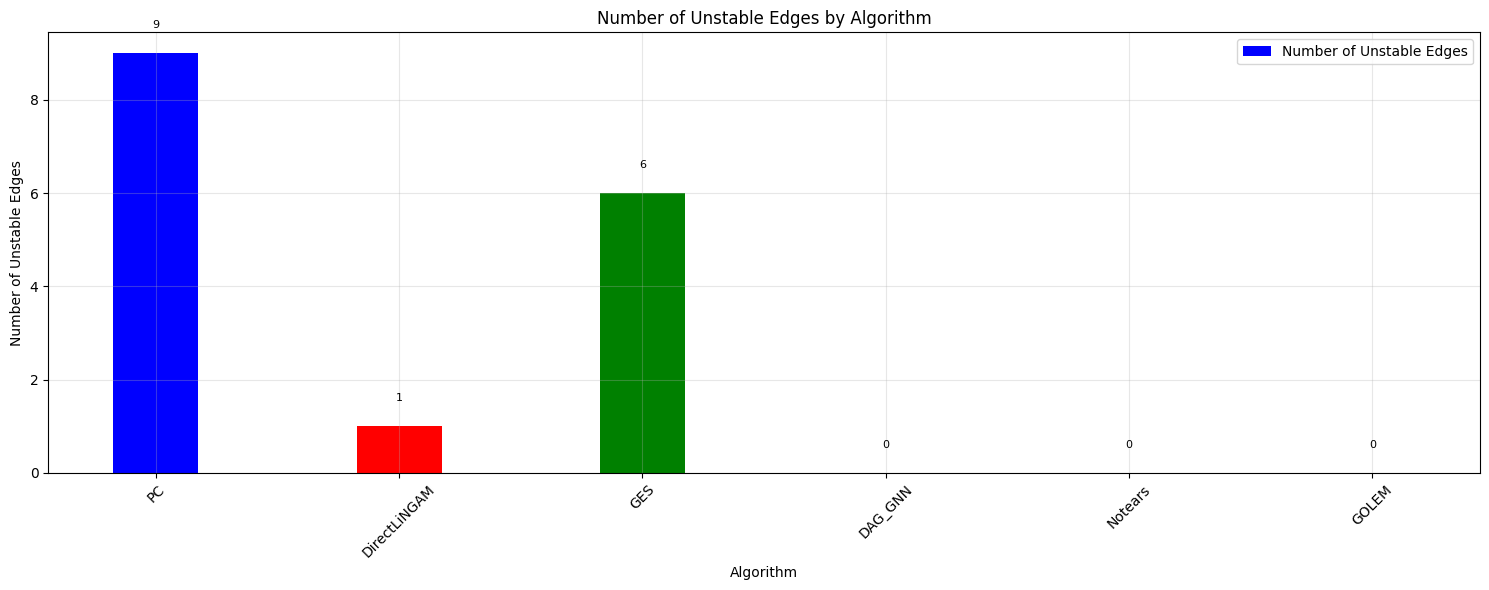

In [13]:
# Plot results
plt.figure(figsize=(15, 6))

# Extract unstable edge counts for each algorithm
unstable_counts = [uncertainty['unstable_count'] for uncertainty in edge_uncertainties.values()]
algo_names = list(edge_uncertainties.keys())

# Create bar plot
x = np.arange(len(algo_names))
width = 0.35

# Use colors defined for each algorithm
bar_colors = [colors[algo] for algo in algo_names]
plt.bar(x, unstable_counts, width, label='Number of Unstable Edges', color=bar_colors, capsize=5)
plt.title('Number of Unstable Edges by Algorithm')
plt.xlabel('Algorithm')
plt.ylabel('Number of Unstable Edges')
plt.xticks(x, algo_names, rotation=45)
plt.grid(True, alpha=0.3)
plt.legend()

# Add value labels on top of bars
for i, count in enumerate(unstable_counts):
    plt.text(i, count + 0.5, f'{count}', 
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

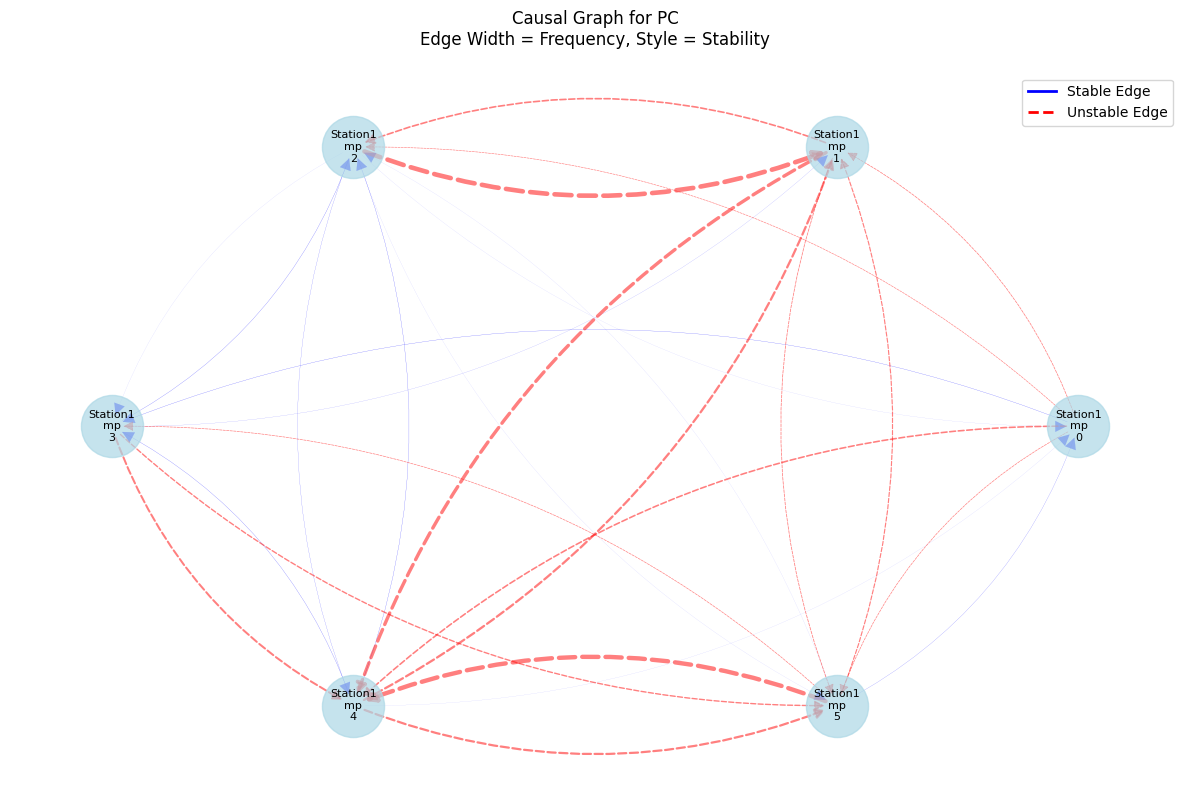

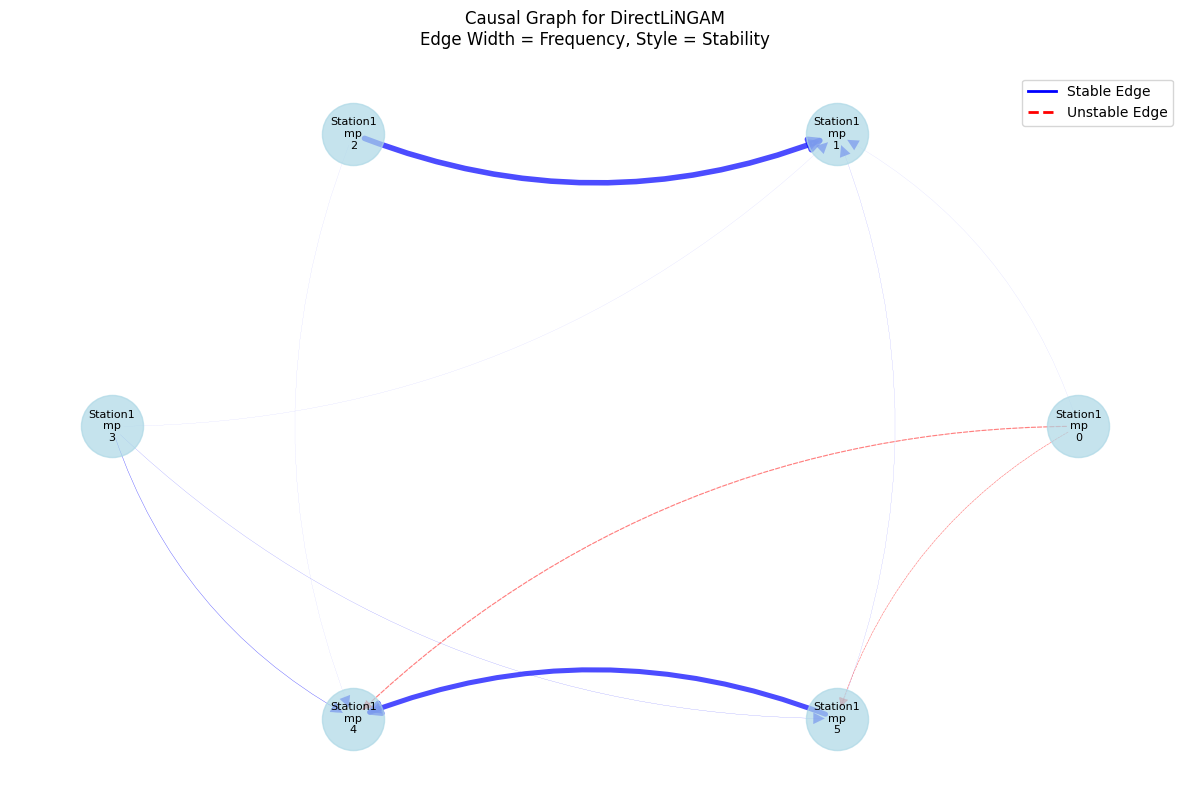

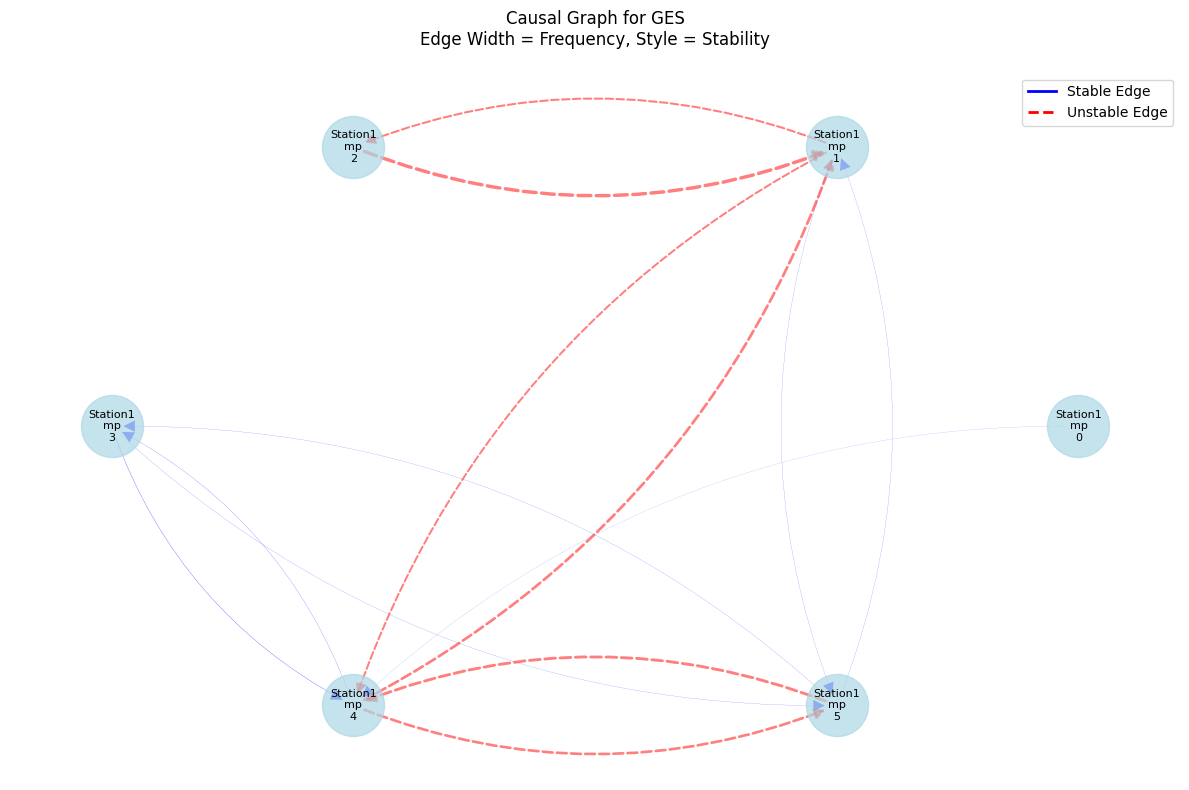

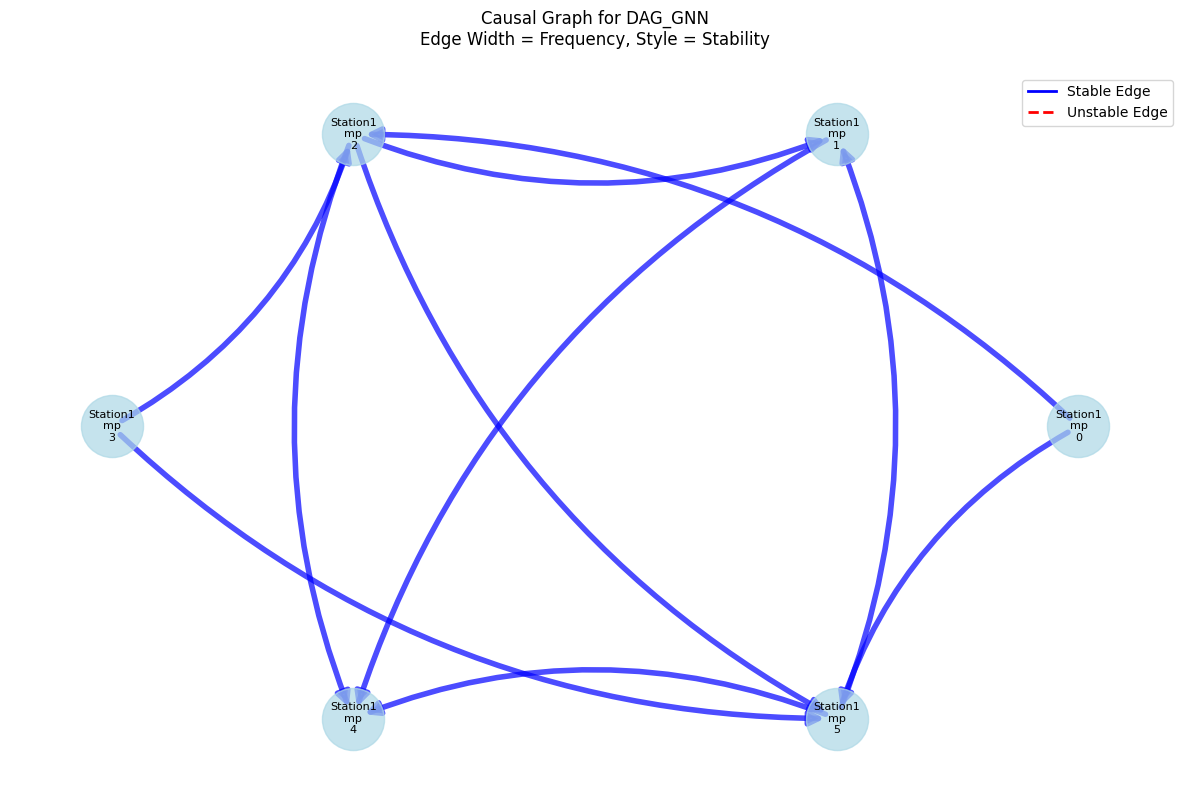

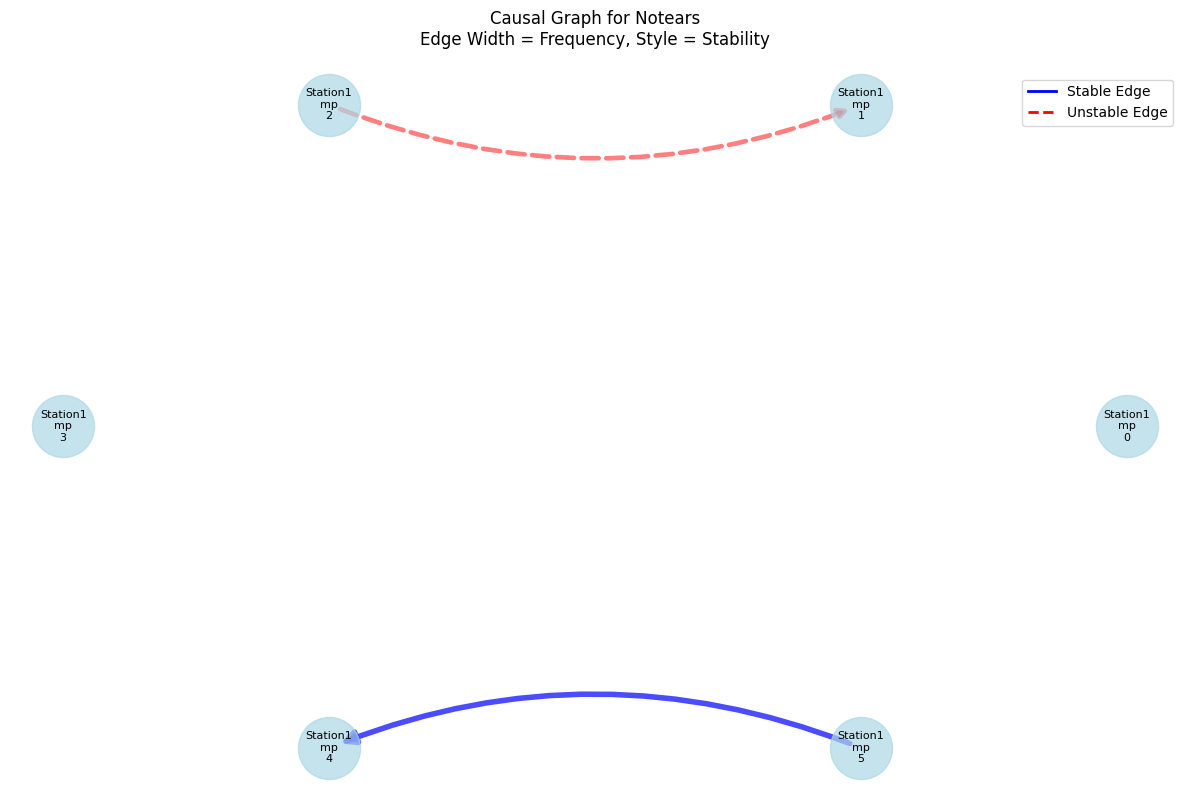

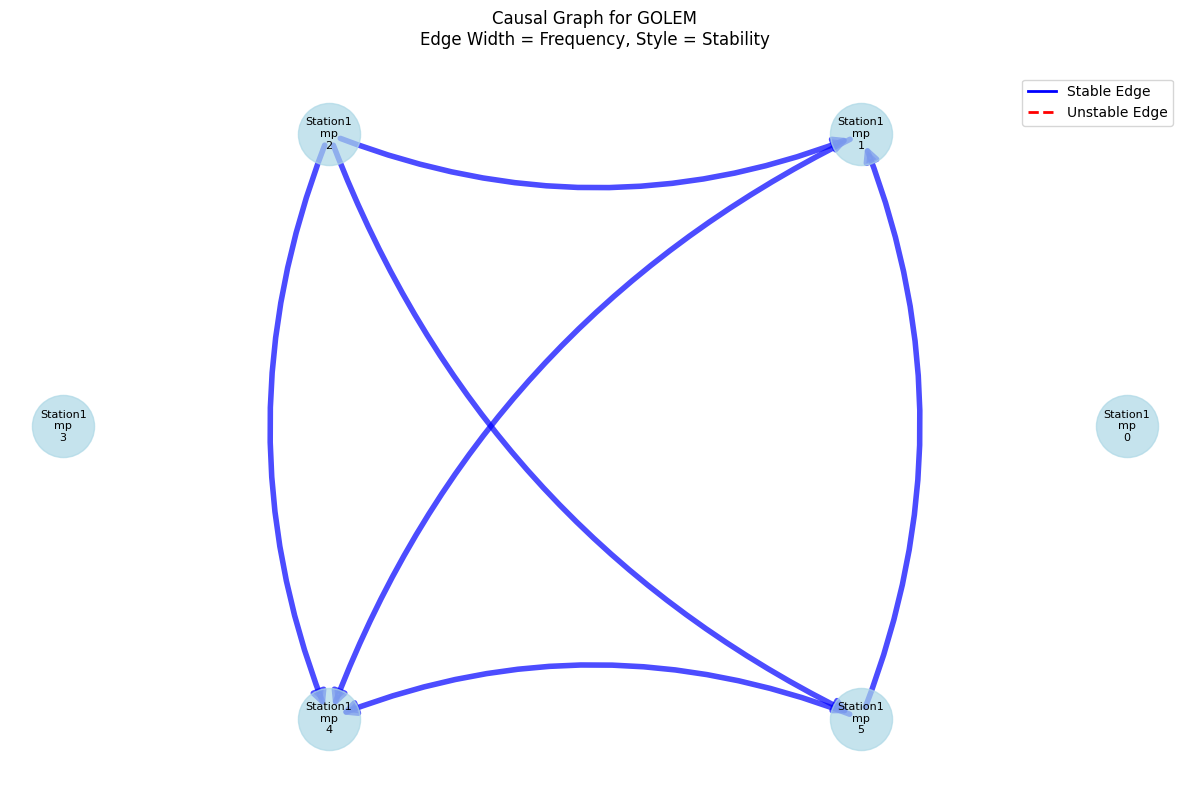

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_causal_graph_with_uncertainty(edge_uncertainties, data, algo_name, stability_threshold=0.9):
    # Get edge information
    edge_freqs = edge_uncertainties[algo_name]['means']
    edge_stds = edge_uncertainties[algo_name]['stds']
    n_vars = int(np.sqrt(len(edge_freqs)))  # Calculate number of variables

    # Get Station1 column names
    station1_cols = [col for col in data.columns if col.startswith('Station1')]

    # Create graph
    G = nx.DiGraph()

    # Add nodes with actual column names
    for col in station1_cols:
        G.add_node(col)

    # Add edges with attributes
    edge_idx = 0
    for i, source in enumerate(station1_cols):
        for j, target in enumerate(station1_cols):
            freq = edge_freqs[edge_idx]
            std = edge_stds[edge_idx]

            # Add edge if frequency is above minimal threshold
            if freq > 0:  # You can adjust this threshold
                is_stable = freq >= stability_threshold or freq <= (1 - stability_threshold)
                G.add_edge(source, target,
                          weight=freq,
                          std=std,
                          is_stable=is_stable)
            edge_idx += 1

    # Create plot
    plt.figure(figsize=(12, 8))

    # Use circular layout for better visualization
    pos = nx.circular_layout(G)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos,
                          node_color='lightblue',
                          node_size=2000,
                          alpha=0.7)

    # Draw node labels with smaller font and wrapped text
    labels = {node: '\n'.join(node.split('_')) for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    # Draw edges with different styles based on stability and uncertainty
    # Stable edges
    stable_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['is_stable']]
    stable_weights = [G[u][v]['weight'] * 4 for (u, v) in stable_edges]

    nx.draw_networkx_edges(G, pos,
                          edgelist=stable_edges,
                          edge_color='blue',
                          width=stable_weights,
                          alpha=0.7,
                          arrowsize=20,
                          connectionstyle='arc3,rad=0.2')

    # Unstable edges
    unstable_edges = [(u, v) for (u, v, d) in G.edges(data=True) if not d['is_stable']]
    unstable_weights = [G[u][v]['weight'] * 4 for (u, v) in unstable_edges]

    nx.draw_networkx_edges(G, pos,
                          edgelist=unstable_edges,
                          edge_color='red',
                          style='dashed',
                          width=unstable_weights,
                          alpha=0.5,
                          arrowsize=15,
                          connectionstyle='arc3,rad=0.2')

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', linewidth=2, label='Stable Edge'),
        Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Unstable Edge')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(f'Causal Graph for {algo_name}\nEdge Width = Frequency, Style = Stability', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

data = pd.read_csv(datasets[min_sample_size])

# Plot for each algorithm
for algo_name in edge_uncertainties.keys():
    plot_causal_graph_with_uncertainty(edge_uncertainties, data, algo_name)